# Imports

In [318]:
import os
import re
import ast
import random
import numpy as np
import pandas as pd
from io import StringIO
from pprint import pprint
from scipy.misc import derivative
from scipy.interpolate import interp1d

In [320]:
from ase.units import Ry
from ase import Atom, Atoms
from ase.io import read, write
from ase.visualize import view
from ase.vibrations import Vibrations
from ase.calculators.siesta import Siesta
from ase.calculators.siesta.parameters import Species

from basis import basisSet
from arguments import singlePointArguments

ModuleNotFoundError: No module named 'basis'

In [289]:
import scienceplots
import matplotlib.pyplot as plt

SMALL_SIZE = 18
MEDIUM_SIZE = 20
BIGGER_SIZE = 22

plt.rc('font', size=SMALL_SIZE)
plt.rc('axes', titlesize=SMALL_SIZE)
plt.rc('axes', labelsize=MEDIUM_SIZE)
plt.rc('xtick', labelsize=SMALL_SIZE)
plt.rc('ytick', labelsize=SMALL_SIZE)
plt.rc('legend', fontsize=SMALL_SIZE)
plt.rc('figure', titlesize=BIGGER_SIZE)

# Constants

In [3]:
c = 299_792_458             # m/s
kB = 8.617_333_262e-5       # eV/K
h = 4.135_667_696e-15       # eV * Hz
hbar = 6.582_119_569e-16    # eV * s

# Definition of the XC functional

In [4]:
PBEpath = '/home/rheinheimer/drive/codes/mestrado/scripts/transitionTube/PBE'
BHpath = '/home/rheinheimer/drive/codes/mestrado/scripts/transitionTube/BH'

baseDir = PBEpath

if baseDir == PBEpath:
    from PBEdata import *

elif baseDir == BHpath:
    from BHdata import *

# Recursive functions

In [219]:
def beta(temperature):
    beta = 1 / (kB * temperature)

    return beta

def normalMode_to_cartesian():
    matrix = np.diagflat([ 16.0000, 1.0079, 1.0079 ])
    finalMatrix = np.sqrt(np.linalg.inv(matrix))

    return finalMatrix

def cartesian_to_normalMode():
    matrix = np.diagflat([ 16.0000, 1.0079, 1.0079 ])
    finalMatrix = np.sqrt(matrix)

    return finalMatrix

def read_geometry(system, baseDir=baseDir):
    geometry = read(f'{baseDir}/initialStructures/{system[0]}/{system[0]}.traj')

    return geometry

def get_water_indexes(system):
    geometry = read_geometry(system)
    oxygenIndex = [atom.index for atom in geometry if atom.symbol == 'O'][0]
    hydrogen2Index = [atom.index for atom in geometry if atom.symbol == 'H'][1]
    waterAtoms = range(oxygenIndex, hydrogen2Index + 1)

    return waterAtoms

# Normal Mode Sampling

In [6]:
def classical_distribution(system, temperature):
    """
    system = system to be sampled
    temperature = temperature of the ensemble

    Returns:
        A random number sampled from a gaussian with the dispersion based on the natural frequency of vibration
    """

    dispersion = lambda a, b : 1 / (np.sqrt(a * (b ** 2)))
    """
    a = beta
    b = eigenvalue

    Returns:
        Dispersion of the classical distribution
    """

    dispersions = [ dispersion(beta(temperature), system[2][i]) for i in range(3) ]
    distributions = [ np.random.normal(loc=0.0, scale=dispersions[i]) for i in range(3) ]

    return distributions

In [7]:
def quantum_distribution(system, temperature):
    """
    system = system to be sampled
    temperature = temperature of the ensemble

    Returns:
        A random number sampled from a gaussian with the dispersion based on the natural frequency of vibration
    """

    dispersion = lambda a, b : 1 / (np.sqrt((2 / (hbar * b)) * np.tanh((a * hbar * b) / 2) * (b ** 2)))
    """
    a = beta
    b = eigenvalue

    Returns:
        Dispersion of the quantum distribution
    """

    dispersions = [ dispersion(beta(temperature), system[2][i]) for i in range(3) ]
    distributions = [ np.random.normal(loc=0.0, scale=dispersions[i]) for i in range(3) ]

    return distributions

In [8]:
def displace_coords(system, temperature, type):
    initialGeometry = read_geometry(system)
    finalGeometry = initialGeometry.copy()

    waterAtoms = get_water_indexes(system)

    if type == 'classical':
        summatory = [ np.abs(classical_distribution(system, temperature)[i]) * system[3][i] for i in range(3) ]
        displacement = np.sum(summatory, axis=0)
        finalGeometry.positions[waterAtoms] = initialGeometry[waterAtoms].get_positions() + displacement

    elif type == 'quantum':
        summatory = [ np.abs(quantum_distribution(system, temperature)[i]) * system[3][i] for i in range(3) ]
        displacement = np.sum(summatory, axis=0)
        finalGeometry.positions[waterAtoms] = initialGeometry[waterAtoms].get_positions() + displacement

    # Condição de ortogonalidade 

    finalGeometryNormalModes = np.array([ np.matmul(cartesian_to_normalMode()[:, i], finalGeometry.positions[waterAtoms][i]) for i in range(3)])
    eigenvectorsNormalModes = np.array([ [np.matmul(cartesian_to_normalMode()[:, i], system[3][j][i]) for i in range(3)] for j in range(3) ])
    dotProduct = np.array([ np.dot(finalGeometryNormalModes, eigenvectorsNormalModes[i]) for i in range(3) ])

    bottomCriteria = -0.001
    upperCriteria = 0.001

    if (bottomCriteria <= dotProduct[0] <= upperCriteria) or (bottomCriteria <= dotProduct[1] <= upperCriteria) or (bottomCriteria <= dotProduct[1] <= upperCriteria):
        return False, finalGeometry

    else:
        return True, finalGeometry


In [9]:
def generate_ensemble(system, temperature, n, outFile, baseDir=baseDir, type='classical'):
    outputPath = f'{baseDir}/finalStructures/{system[0]}'

    if not os.path.exists(outputPath):
        os.makedirs(outputPath)

    ensemble = []
    countTrue = 0
    countFalse = 0

    for i in range(n):
        condition, geometry = displace_coords(system, temperature, type)

        if condition == False:
            countFalse = countFalse + 1
            pass

        elif condition == True:
            countTrue = countTrue + 1
            ensemble.append(geometry)

    write(filename=f'{outputPath}/{outFile}', images=ensemble, format='xyz')

    return ensemble

In [10]:
# Isolated
isolatedSystem = get_system_data(isolated)
generate_ensemble(isolatedSystem, 300, 1, 'classical.xyz');

# Flat
flatSystem = get_system_data(flat)
generate_ensemble(flatSystem, 300, 100, 'classical.xyz');

# Up
upSystem = get_system_data(up)
generate_ensemble(upSystem, 300, 100, 'classical.xyz');

# Down
downSystem = get_system_data(down)
generate_ensemble(downSystem, 300, 100, 'classical.xyz');

# Transition Tube Sampling

In [278]:
def get_neb():
    nebFiles = [ neb_initial, neb_image_1, neb_image_2, neb_image_3, neb_final ]
    nebData = [ get_system_data(system) for system in nebFiles ]
    nebStructures = [ read_geometry(system) for system in nebData ]

    return nebData, nebStructures

In [279]:
neb = get_neb()

oxygenIndex = [atom.index for atom in neb[1][0] if atom.symbol == 'O'][0]
hydrogen1Index = [atom.index for atom in neb[1][0] if atom.symbol == 'H'][0]
hydrogen2Index = [atom.index for atom in neb[1][0] if atom.symbol == 'H'][1]

In [280]:
def separate_atoms_coordinates():
    neb = get_neb()

    # Primeiro índice: Estrutura do neb [0, 5]
    # Segundo índice: Seleciona o átomo [0, 67]
    # Terceiro índice: Seleciona a coordenada (x, y, z) [0, 3]

    xPositions = np.array([ [ neb[1][i].positions[j][0] for j in range(len(neb[1][0])) ] for i in range(len(neb[1])) ])
    yPositions = np.array([ [ neb[1][i].positions[j][1] for j in range(len(neb[1][0])) ] for i in range(len(neb[1])) ])
    zPositions = np.array([ [ neb[1][i].positions[j][2] for j in range(len(neb[1][0])) ] for i in range(len(neb[1])) ])

    return xPositions, yPositions, zPositions

In [281]:
def interpolate_neb(qsi, qsiInterpolation):
    data = separate_atoms_coordinates()

    xInterpolation = [ interp1d(qsi, data[0][:, i], kind='cubic', fill_value='extrapolate') for i in range(len(data[0][0])) ]
    yInterpolation = [ interp1d(qsi, data[1][:, i], kind='cubic', fill_value='extrapolate') for i in range(len(data[0][0])) ]
    zInterpolation = [ interp1d(qsi, data[2][:, i], kind='cubic', fill_value='extrapolate') for i in range(len(data[0][0])) ]

    xPositionsInterpolation = np.array([ xInterpolation[i](qsiInterpolation) for i in range(len(xInterpolation)) ])
    yPositionsInterpolation = np.array([ yInterpolation[i](qsiInterpolation) for i in range(len(yInterpolation)) ])
    zPositionsInterpolation = np.array([ zInterpolation[i](qsiInterpolation) for i in range(len(zInterpolation)) ])

    return xPositionsInterpolation, yPositionsInterpolation, zPositionsInterpolation

In [282]:
# Qsi dos pontos de controles
controlPoints = np.linspace(0, 1, num=5)

# Qsi da interpolação
controlPointsInterpolation = np.linspace(0, 1, 1000)

atomsPositions = separate_atoms_coordinates()
atomsPositionsInterpolation = interpolate_neb(controlPoints, controlPointsInterpolation)

In [29]:
def transitionTubeDensity():
    sinProb = lambda a, b, c : np.sin((np.pi * (a - c)) / (2 * abs(b - c)))**2
    # a = qsiInterpolation
    # b = qsi at controol point
    # c = qsi at controol point - 1

    cosProb = lambda a, b, c : np.cos((np.pi * (a - b)) / (2 * abs(b - c))) ** 2
    # a = qsiInterpolation
    # b = qsi at controol point
    # c = qsi at controol point + 1

    probabilityDistribution = []

    for i in range(len(controlPoints)):
        if i == 0:
            for j in range(len(controlPointsInterpolation)):
                if controlPointsInterpolation[j] <= controlPoints[i + 1]:
                    probabilityDistribution.append(cosProb(controlPointsInterpolation[j], controlPoints[i], controlPoints[i + 1]))

                else:
                    probabilityDistribution.append(0)

        elif i == 4:
            for j in range(len(controlPointsInterpolation)):
                if controlPoints[i - 1] <= controlPointsInterpolation[j] <= controlPoints[i]:
                    probabilityDistribution.append(sinProb(controlPointsInterpolation[j], controlPoints[i], controlPoints[i - 1]))

                else:
                    probabilityDistribution.append(0)

        else:
            for j in range(len(controlPointsInterpolation)):
                if controlPoints[i - 1] <= controlPointsInterpolation[j] <= controlPoints[i]:
                    probabilityDistribution.append(sinProb(controlPointsInterpolation[j], controlPoints[i], controlPoints[i - 1]))

                elif controlPoints[i] <= controlPointsInterpolation[j] <= controlPoints[i + 1]:
                    probabilityDistribution.append(cosProb(controlPointsInterpolation[j], controlPoints[i], controlPoints[i + 1]))

                else:
                    probabilityDistribution.append(0)

    return np.array(probabilityDistribution)

In [211]:
# Qsi da distribuição de probabilidade
probabilityDistribution = transitionTubeDensity()
reactionCoordinate = np.linspace(0, 1, len(probabilityDistribution))

In [290]:
def get_sample_points(nTries):
    probabilityDistribution = transitionTubeDensity()
    samplePoints = []
    i = 0

    while i < nTries:
        randomPoint = np.random.choice(probabilityDistribution)

        if randomPoint <= 0.01:
            samplePoints.append(None)

        else:
            randomPointIndex = np.where(probabilityDistribution == randomPoint)
            qsi_ = reactionCoordinate[randomPointIndex]

            samplePoints.append(qsi_)

        i = i + 1

    # Removendo os valores None da lista de pontos (correspondentes a 0)
    removingNones = [ x for x in samplePoints if x is not None ]

    # Removendo os arrays (Cada elemento da lista é um array, faz mais sentido organizar em uma lista comum com cada elemento sendo um float)
    removingArrays = [ [ removingNones[i][j] for j in range(len(removingNones[i])) ] for i in range(len(removingNones)) ]

    # Algumas entradas da lista também são listas, aqui os valores são reorganizados em uma única lista unidimensional
    orderingList = [ item for sublist in removingArrays for item in sublist ]

    # Comparando quais pontos da lista sampleada equivale aos pontos da lista de interpolação
    tolerance = 1e-4
    selectedSamplePoints = [element for element in controlPointsInterpolation if any(np.isclose(element, val, atol=tolerance) for val in orderingList)]

    # Obtendo os índices da lista de interpolação referentes aos valores sampleados
    selectedSamplePointsIndexes = [ np.where(np.isin(controlPointsInterpolation, selectedSamplePoints[i])) for i in range(len(selectedSamplePoints)) ]

    # Removendo os arrays (igual feito anteriormente)
    selectedSamplePointsIndexesRemovingArrays = [ selectedSamplePointsIndexes[i][0][0] for i in range(len(selectedSamplePointsIndexes)) ]

    return selectedSamplePointsIndexesRemovingArrays

In [321]:
def create_geometries():
    samplePoints = get_sample_points(100000)
    systemsList = []

    # Primeiro índice: Coordenada (x, y, z) [0, 3]
    # Segundo índice: Átomo selecionado [0, 67]
    # Terceiro índice: ponto da coordenada de reação [0, 1000]

    for i in range(len(samplePoints)):
        goldAtoms = [ Atom('Au', (atomsPositionsInterpolation[0][j][i], atomsPositionsInterpolation[1][j][i], atomsPositionsInterpolation[2][j][i])) for j in range(0, oxygenIndex) ]

        oxygenAtoms = Atom('O', (atomsPositionsInterpolation[0][oxygenIndex][i], atomsPositionsInterpolation[1][oxygenIndex][i], atomsPositionsInterpolation[2][oxygenIndex][i]))

        hydrogen1Atoms = Atom('H', (atomsPositionsInterpolation[0][hydrogen1Index][i], atomsPositionsInterpolation[1][hydrogen1Index][i], atomsPositionsInterpolation[2][hydrogen1Index][i]))

        hydrogen2Atoms = Atom('H', (atomsPositionsInterpolation[0][hydrogen2Index][i], atomsPositionsInterpolation[1][hydrogen2Index][i], atomsPositionsInterpolation[2][hydrogen2Index][i]))

        goldAtoms.append(oxygenAtoms)
        goldAtoms.append(hydrogen1Atoms)
        goldAtoms.append(hydrogen2Atoms)

        system = Atoms(goldAtoms)
        systemsList.append(system)

    write(filename=f'referenceGeometries.traj', images=systemsList, format='traj')
    write(filename=f'referenceGeometries.xyz', images=systemsList, format='xyz')

    return systemsList

In [322]:
referenceGeometries = create_geometries()

In [ ]:
for j in range(len(referenceGeometries)):
    system = referenceGeometries[j]

    for k in range(0, oxygenIndex):
        if k <= 31:
            system[k].tag = 1
        elif k >= 32:
            system[k].tag = 2

    siesta = Siesta(
        label=f'structure-{j}',
        mesh_cutoff=700*Ry,
        kpts=[1, 1, 1],
        xc="PBE",
        species=[
            Species(symbol="H", basis_set=basisSet("H"), pseudopotential="H.psf"),
            Species(symbol="O", basis_set=basisSet("O"), pseudopotential="O.psf"),
            Species(symbol='Au', basis_set=basisSet('Au2'), pseudopotential='Au.gga.psf', tag=1),
            Species(symbol='Au', basis_set=basisSet('Au3'), pseudopotential='Au.gga.psf', tag=1)
        ],
        fdf_arguments=singlePointArguments(),
    )

    system.calc = siesta

    if not os.path.exists(f'estrutura-{j}'):
        os.makedirs(f'structure-{j}')
        os.chdir(f'structure-{j}')

        vib = Vibrations(
            atoms=system,
            indices=[
                [atom.index for atom in system if atom.symbol == 'O'][0],
                [atom.index for atom in system if atom.symbol == 'H'][0],
                [atom.index for atom in system if atom.symbol == 'H'][1]
            ],
            name=f'structure-{j}',
            delta=0.02,
            nfree=2
        )

        vib.run()
        print(vib.get_vibrations().get_energies_and_modes())
        vib.summary()

    system = None
    siesta = None

In [120]:
def get_data_from_slurm(slurmFile):
    initialWord = "array"
    finalWord = "Zero-point energy"

    with open(slurmFile, 'r') as file:
        lines = file.readlines()
        data = []

        i = 0
        while i < len(lines):
            initialIndex = next((j for j, line in enumerate(lines[i:], start=i) if initialWord in line), None)

            if initialIndex is None:
                break

            finalIndex = next((j for j, line in enumerate(lines[initialIndex:], start=initialIndex) if finalWord in line), None)

            if finalIndex is None:
                break

            dataBlock = ''.join(lines[initialIndex:finalIndex + 1])
            data.append(dataBlock)

            i = finalIndex + 1

    lines = [ data[i].split('\n') for i in range(len(data)) ]

    initialIndex = [ lines[i].index('---------------------') + 3 for i in range(len(data)) ]
    finalIndex = [ lines[i].index('---------------------', initialIndex[i]) for i in range(len(data)) ]

    eigenvaluesTable = [ '\n'.join(lines[i][initialIndex[i]:finalIndex[i]]) for i in range(len(data))]
    eigenvaluesTableIO = [ StringIO(eigenvaluesTable[i]) for i in range(len(data)) ]

    dfList = [ pd.read_csv(eigenvaluesTableIO[i], delim_whitespace=True, header=None) for i in range(len(data))]

    _eigenvalues = [ dfList[i].iloc[:, 2][-3:].values for i in range(len(data)) ]
    eigenvalues = [ [ float(value) for value in _eigenvalues[i] ] for i in range(len(_eigenvalues)) ]

    arrayPattern = r'array\((.*?)\)'
    values = [ re.findall(arrayPattern, data[i], re.DOTALL) for i in range(len(data)) ]

    energies = []
    eigenvectors = []

    for i in range(len(values)):
        _energy = ast.literal_eval(values[i][0])
        energy = np.real(_energy[-3:])
        energies.append(energy)

        _eigenvector = ast.literal_eval(values[i][1])
        eigenvector = _eigenvector[-3:]
        eigenvectors.append(eigenvector)

    return energies, eigenvalues, eigenvectors

In [ ]:
data = get_data_from_slurm('slurm-16615.out')
print(data[2])

[[[[0.05504838, -0.0382619, 0.01100247], [-0.66707872, -0.02764209, -0.16535032], [-0.20587847, 0.63506234, -0.00442364]], [[-0.02955777, 0.04011648, -0.00525801], [0.01263461, -0.82903811, -0.05221807], [0.45623045, 0.19286797, 0.12915]], [[-0.04482352, -0.04678399, -0.01472354], [-0.04418041, 0.49455005, 0.0214194], [0.7548051, 0.2478307, 0.2094098]]], [[[-0.00200970961, -0.000675969983, -0.0687134569], [0.421848555, 0.00684208402, 0.559777521], [-0.39127443, 0.00461813413, 0.522092764]], [[0.0351089886, -0.000383212462, -0.0415256004], [-0.767445548, 0.00582145031, 0.548672459], [0.210098615, 0.00109691846, 0.10457852]], [[-0.0578464332, -0.000220797354, -0.0252437407], [0.156036821, -0.00157873331, -0.149729372], [0.761889762, 0.00508687097, 0.549150665]]], [[[-0.00164326503, 0.000648265382, -0.0685098338], [-0.395281434, -0.00420058003, 0.521188475], [0.426243945, -0.00444638837, 0.554897215]], [[0.0349399283, 0.000292349868, -0.0414407571], [0.207930893, -0.000854779875, 0.104861

# Plots

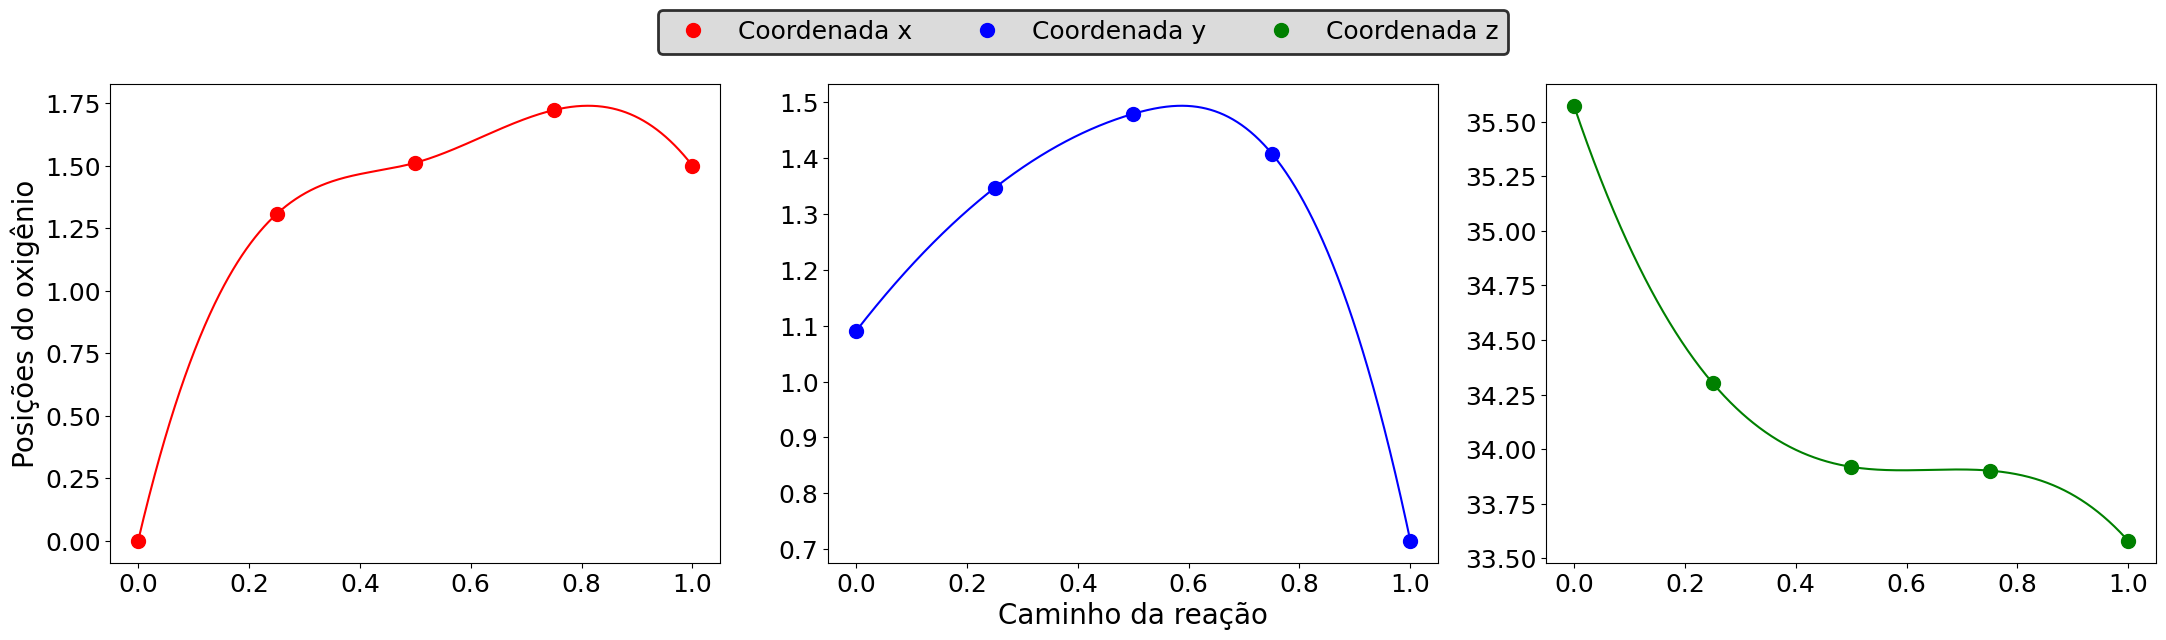

In [247]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(22, 6))

ax[1].set_xlabel('Caminho da reação')
ax[0].set_ylabel('Posições do oxigênio')

ax[0].plot(controlPoints, atomsPositions[0][:, oxygenIndex], 'o', markersize=10, color='red', label='Coordenada x')
ax[0].plot(controlPointsInterpolation, atomsPositionsInterpolation[0][oxygenIndex], color='red')

ax[1].plot(controlPoints, atomsPositions[1][:, oxygenIndex], 'o', markersize=10, color='blue', label='Coordenada y')
ax[1].plot(controlPointsInterpolation, atomsPositionsInterpolation[1][oxygenIndex], color='blue')

ax[2].plot(controlPoints, atomsPositions[2][:, oxygenIndex], 'o', markersize=10, color='green', label='Coordenada z')
ax[2].plot(controlPointsInterpolation, atomsPositionsInterpolation[2][oxygenIndex], color='green')

legend = fig.legend(loc='upper center', bbox_to_anchor=(0.5, 1.10), ncol=3)
legend.get_frame().set_facecolor('lightgray')
legend.get_frame().set_edgecolor('black')
legend.get_frame().set_linewidth(2)

plt.tight_layout()
plt.show()

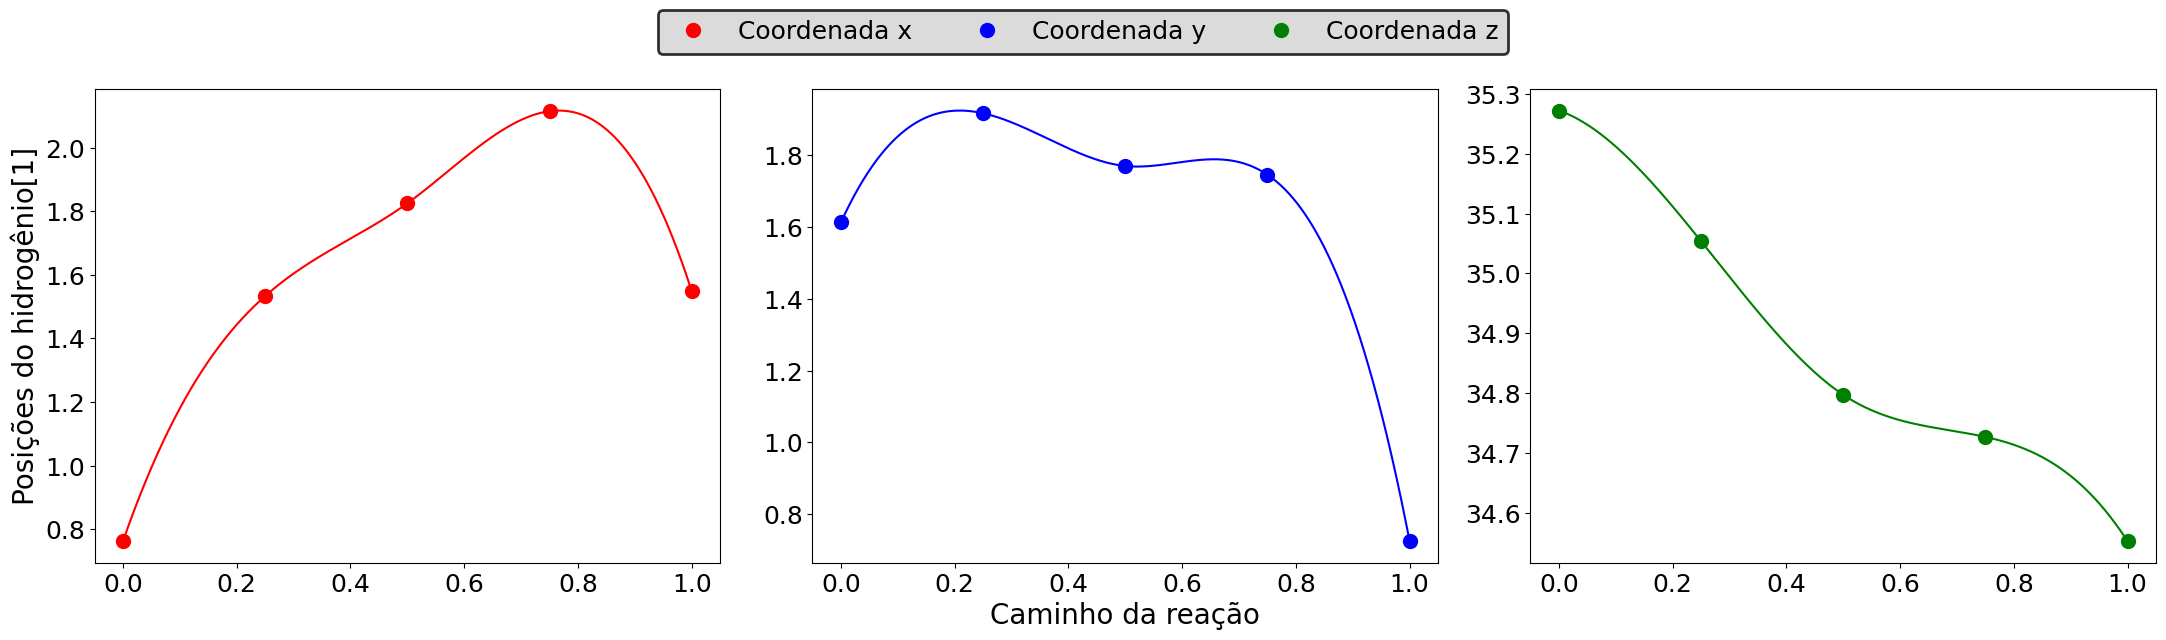

In [249]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(22, 6))

ax[1].set_xlabel('Caminho da reação')
ax[0].set_ylabel('Posições do hidrogênio[1]')

ax[0].plot(controlPoints, atomsPositions[0][:, hydrogen1Index], 'o', markersize=10, color='red', label='Coordenada x')
ax[0].plot(controlPointsInterpolation, atomsPositionsInterpolation[0][hydrogen1Index], color='red')

ax[1].plot(controlPoints, atomsPositions[1][:, hydrogen1Index], 'o', markersize=10, color='blue', label='Coordenada y')
ax[1].plot(controlPointsInterpolation, atomsPositionsInterpolation[1][hydrogen1Index], color='blue')

ax[2].plot(controlPoints, atomsPositions[2][:, hydrogen1Index], 'o', markersize=10, color='green', label='Coordenada z')
ax[2].plot(controlPointsInterpolation, atomsPositionsInterpolation[2][hydrogen1Index], color='green')

legend = fig.legend(loc='upper center', bbox_to_anchor=(0.5, 1.10), ncol=3)
legend.get_frame().set_facecolor('lightgray')
legend.get_frame().set_edgecolor('black')
legend.get_frame().set_linewidth(2)

plt.tight_layout()
plt.show()

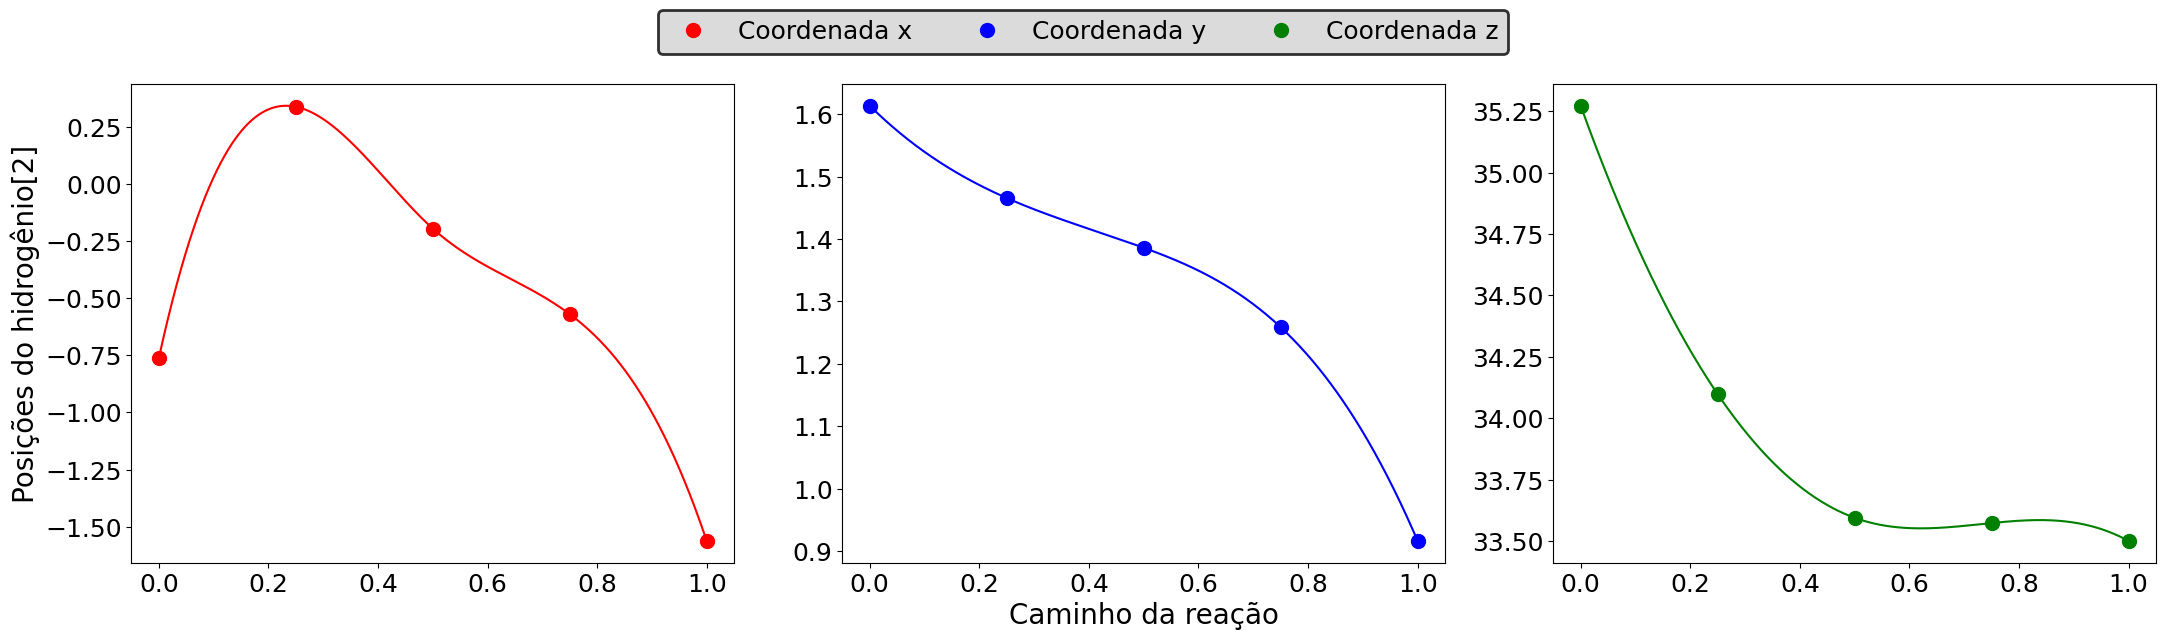

In [250]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(22, 6))

ax[1].set_xlabel('Caminho da reação')
ax[0].set_ylabel('Posições do hidrogênio[2]')

ax[0].plot(controlPoints, atomsPositions[0][:, hydrogen2Index], 'o', markersize=10, color='red', label='Coordenada x')
ax[0].plot(controlPointsInterpolation, atomsPositionsInterpolation[0][hydrogen2Index], color='red')

ax[1].plot(controlPoints, atomsPositions[1][:, hydrogen2Index], 'o', markersize=10, color='blue', label='Coordenada y')
ax[1].plot(controlPointsInterpolation, atomsPositionsInterpolation[1][hydrogen2Index], color='blue')

ax[2].plot(controlPoints, atomsPositions[2][:, hydrogen2Index], 'o', markersize=10, color='green', label='Coordenada z')
ax[2].plot(controlPointsInterpolation, atomsPositionsInterpolation[2][hydrogen2Index], color='green')


legend = fig.legend(loc='upper center', bbox_to_anchor=(0.5, 1.10), ncol=3)
legend.get_frame().set_facecolor('lightgray')
legend.get_frame().set_edgecolor('black')
legend.get_frame().set_linewidth(2)

plt.tight_layout()
plt.show()

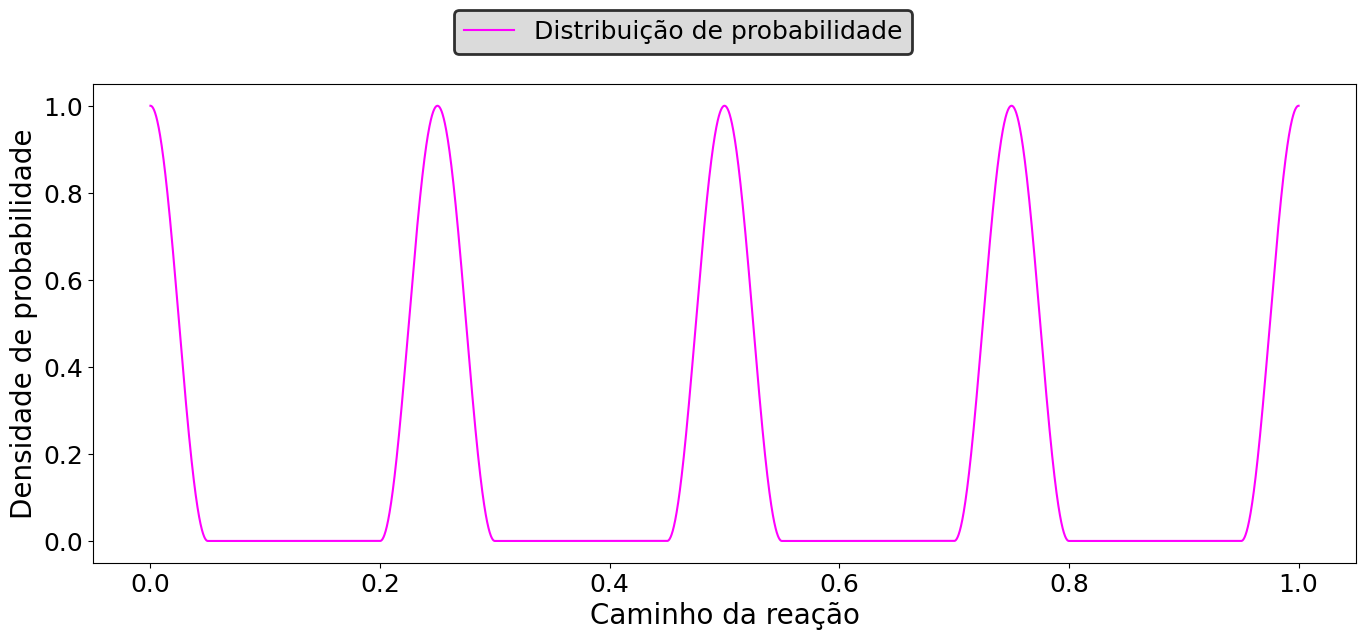

In [251]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(14, 6))

ax.plot(reactionCoordinate, probabilityDistribution, color='magenta', label='Distribuição de probabilidade')
ax.set_xlabel('Caminho da reação')
ax.set_ylabel('Densidade de probabilidade')

legend = fig.legend(loc='upper center', bbox_to_anchor=(0.5, 1.10), ncol=3)
legend.get_frame().set_facecolor('lightgray')
legend.get_frame().set_edgecolor('black')
legend.get_frame().set_linewidth(2)

plt.tight_layout()
plt.show()